# Annotating images Using labelMe

In [ ]:
!labelme

# Resize Images if images with different sizes only

In [13]:
import PIL
import os
import os.path
from PIL import Image


path = 'data/originalImages'
for file in os.listdir(path): 
    f_img = path+"/"+file
    img = Image.open(f_img)

    img = img.resize((750, 469)) #(width, height)
    s_path = 'data/images/'+file
    img.save(s_path)

# 2 Building Image Loading Function

### 2.1 Importing TF Dependencies 

In [14]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [27]:
images = tf.data.Dataset.list_files('data\\images\\*.jpeg', shuffle=True)

In [28]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [29]:
images = images.map(load_image)

In [30]:
images.as_numpy_iterator().next()
# type(images)

array([[[ 21,  49,   9],
        [ 14,  42,   1],
        [ 53,  80,  35],
        ...,
        [ 91,  92,  84],
        [ 92,  93,  85],
        [ 93,  94,  86]],

       [[ 53,  81,  41],
        [ 32,  60,  19],
        [ 18,  45,   0],
        ...,
        [ 91,  92,  84],
        [ 91,  92,  84],
        [ 91,  92,  84]],

       [[ 91, 122,  81],
        [ 47,  78,  36],
        [  0,  21,   0],
        ...,
        [ 93,  94,  86],
        [ 92,  93,  85],
        [ 90,  91,  83]],

       ...,

       [[102, 105,  86],
        [154, 157, 138],
        [224, 227, 208],
        ...,
        [ 36,  45,  50],
        [ 35,  44,  49],
        [ 33,  42,  47]],

       [[159, 162, 143],
        [207, 210, 191],
        [182, 185, 166],
        ...,
        [ 37,  46,  51],
        [ 39,  48,  53],
        [ 39,  48,  53]],

       [[210, 213, 194],
        [218, 221, 202],
        [174, 177, 158],
        ...,
        [ 35,  44,  49],
        [ 40,  49,  54],
        [ 42,  51,  56]]

In [31]:
images_generator = images.batch(4).as_numpy_iterator()

In [32]:
plot_images = images_generator.next()

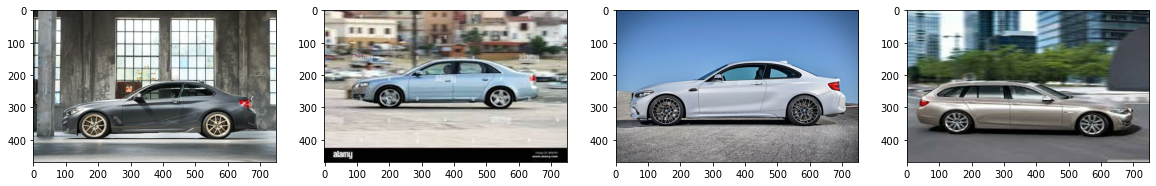

In [33]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

### divide imageset into train, test and val

##### train = total * 0.7 = 87
##### test = total * 0.15 = 18
##### val = total * 0.15 = 18

### Moving labels to train, test & val folders

In [35]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels',filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data', folder, 'labels',filename)
            os.replace(existing_filepath, new_filepath)

## 3. Image Augmentation

In [38]:
import albumentations as alb
import cv2

### 3.1 One image demonstration

In [63]:
augmentor = alb.Compose([alb.RandomCrop(width=460, height=460),
                        alb.HorizontalFlip(p=0.5),
                        alb.RandomBrightnessContrast(p=0.2),
                        alb.RandomGamma(p=0.2),
                        alb.RGBShift(p=0.2),
                        alb.VerticalFlip(p=0.5)],
                    bbox_params= alb.BboxParams(format='albumentations',
                        label_fields=['class_labels']))

In [64]:
img = cv2.imread(os.path.join('data','train','images','0a409f4c-e3d0-46b9-b889-9f58d090a051.jpeg'))

In [65]:
with open(os.path.join('data','train','labels','0a409f4c-e3d0-46b9-b889-9f58d090a051.json'), 'r') as f:
    label = json.load(f)

In [66]:
label['shapes']

[{'label': 'side-view',
  'points': [[426.02702702702703, 265.64864864864865],
   [485.4864864864865, 369.7027027027027]],
  'group_id': None,
  'shape_type': 'rectangle',
  'flags': {}}]

### 3.2 Extract Coordinates 

In [67]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

coords

[426.02702702702703, 265.64864864864865, 485.4864864864865, 369.7027027027027]

In [68]:
coords = list(np.divide(coords, [750,469,750,469]))

In [69]:
coords

[0.568036036036036, 0.5664150291015962, 0.6473153153153154, 0.8037015276145711]

In [70]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['side-view'])

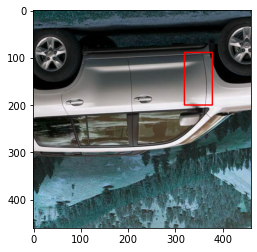

In [74]:
cv2.rectangle(augmented['image'],
                tuple(np.multiply(augmented['bboxes'][0][:2],[460,460]).astype(int)), # top coordinate
                tuple(np.multiply(augmented['bboxes'][0][2:],[460,460]).astype(int)), # bottom coordinate
                (250,0,0),2) # color and thinkness of rectangle 

plt.imshow(augmented['image'])

### 3.3 Transforming all images

In [81]:
for partition in ['train','test','val']:
    for image in os.listdir(os.path.join('data',partition,'images')):
        img = cv2.imread(os.path.join('data',partition, 'images', image ))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data',partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)
            
            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [750,469,750,469]))

        try:
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['side-view'])
                cv2.imwrite(os.path.join('data','aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpeg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0:
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0
                    else:
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else:
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0
                
                with open(os.path.join('data','aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)
        except Exception as e:
            print(e)

### 3.4 Loading Transformed images

In [83]:
train_images = tf.data.Dataset.list_files('data\\aug_data\\train\\images\\*.jpeg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x , (120,120)))
train_images = train_images.map(lambda x: x/255)

In [85]:
test_images = tf.data.Dataset.list_files('data\\aug_data\\test\\images\\*.jpeg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x , (120,120)))
test_images = test_images.map(lambda x: x/255)

In [87]:
val_images = tf.data.Dataset.list_files('data\\aug_data\\val\\images\\*.jpeg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x , (120,120)))
val_images = val_images.map(lambda x: x/255)